<a href="https://colab.research.google.com/github/fahm8/NLP_UTS/blob/main/kelompok_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data & package

In [ ]:
!pip install jcopml
!pip install contractions

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.7-py2.py3-none-any.whl size=45916 sha256=dd5ff518486dee7986987036452f94aeabdee1860cd325193262a5757fe605d1
  Stored in directory: /root/.cache/pip/wheels/77/a7/60/c75983f4da5b630422325c5048591b6ee9e2ce123bf2b7b357
Successfully built jcopml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 11.1 MB/s eta 0:00:00


In [ ]:
#Import Library
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from scipy.stats import chi2
import spacy
from sklearn.covariance import MinCovDet
import math
import re
from collections import defaultdict
from wordcloud import WordCloud
import os
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Data
url = "https://raw.githubusercontent.com/fahm8/NLP_UTS/main/train.csv"
df = pd.read_csv(url)
N, P = df.shape # Ukuran Data
print('baris = ', N, ', Kolom (jumlah variabel) = ', P)
print("Tipe Variabe df = ", type(df))
df.head()

baris =  7613 , Kolom (jumlah variabel) =  5
Tipe Variabe df =  <class 'pandas.core.frame.DataFrame'>


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


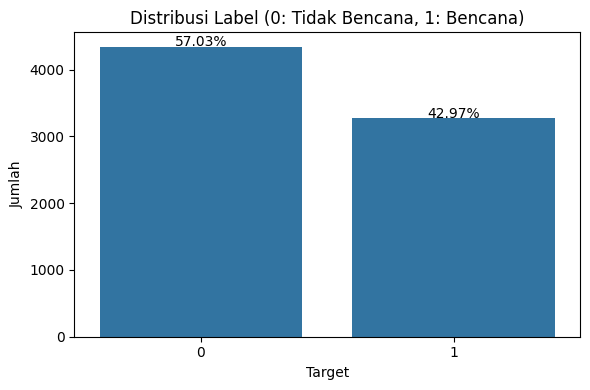

Persentase masing-masing label (%):
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(6,4))
ax = sns.countplot(x='target', data=df)
plt.title('Distribusi Label (0: Tidak Bencana, 1: Bencana)')

# Hitung total dan persentase
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 5, f'{percentage}', ha='center', fontsize=10)

plt.xlabel('Target')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()
print("Persentase masing-masing label (%):")
print(df['target'].value_counts(normalize=True) * 100)


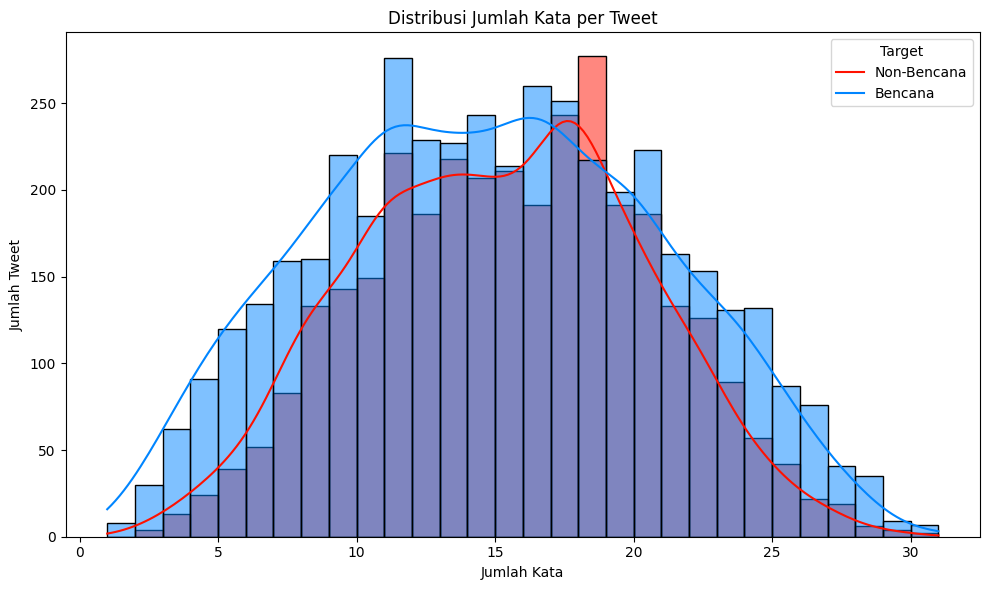

In [ ]:
# Hitung jumlah kata
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Histogram jumlah kata per target (pakai hue)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='target', kde=True, bins=30,
             palette={0: '#0085ff', 1: '#ff1100'})  # Biru utk 0, Merah utk 1
plt.title('Distribusi Jumlah Kata per Tweet')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Tweet')
plt.legend(title='Target', labels=['Non-Bencana', 'Bencana'])
plt.tight_layout()
plt.show()


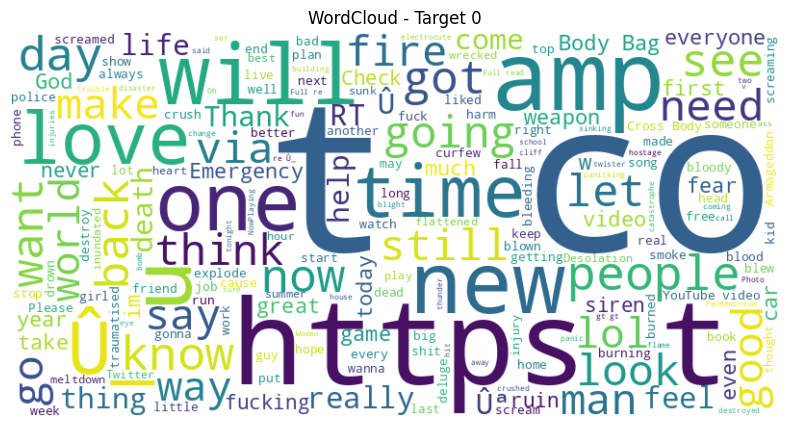

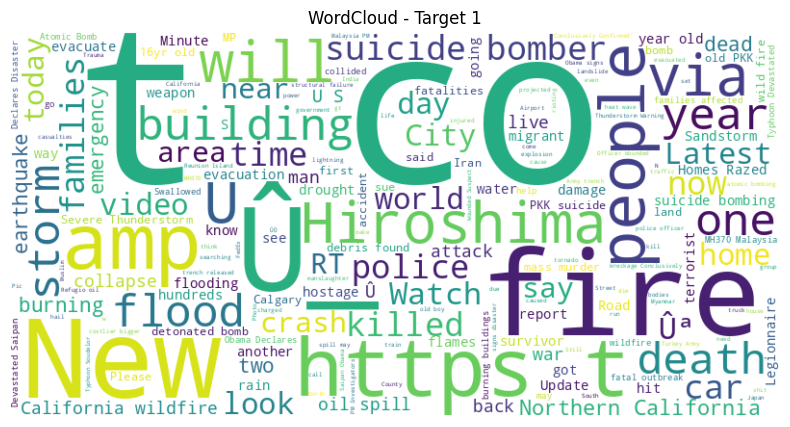

In [ ]:
def plot_wordcloud(label):
    text = ' '.join(df[df['target']==label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - Target {label}')
    plt.show()

plot_wordcloud(0)  # Tidak bencana
plot_wordcloud(1)  # Bencana


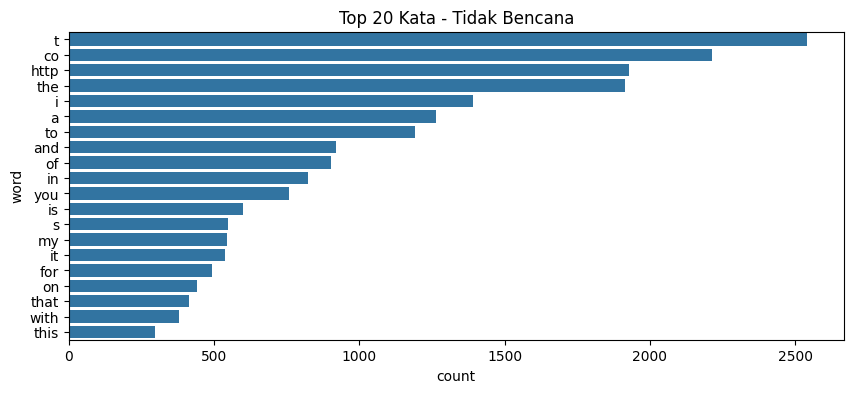

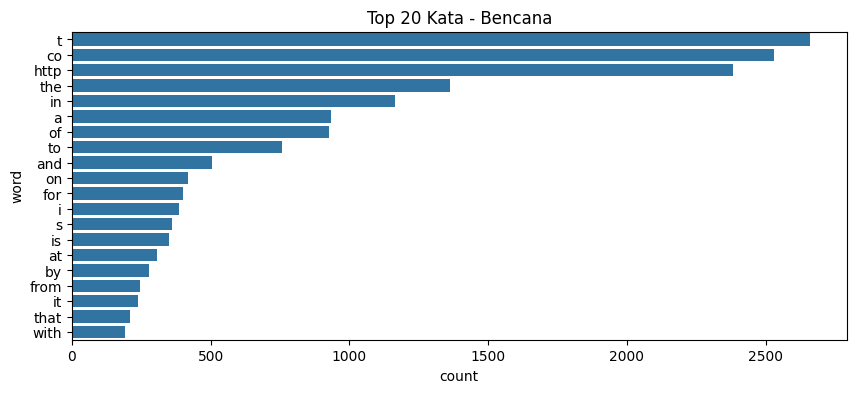

In [ ]:
from collections import Counter
import re

def get_top_words(label, n=20):
    tweets = df[df['target']==label]['text']
    words = ' '.join(tweets).lower()
    words = re.findall(r'\b\w+\b', words)
    common = Counter(words).most_common(n)
    return pd.DataFrame(common, columns=['word', 'count'])

# Top words
top_words_0 = get_top_words(0)
top_words_1 = get_top_words(1)

# Visualisasi
plt.figure(figsize=(10,4))
sns.barplot(x='count', y='word', data=top_words_0)
plt.title('Top 20 Kata - Tidak Bencana')
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x='count', y='word', data=top_words_1)
plt.title('Top 20 Kata - Bencana')
plt.show()


/tmp/ipython-input-10-577032080.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')


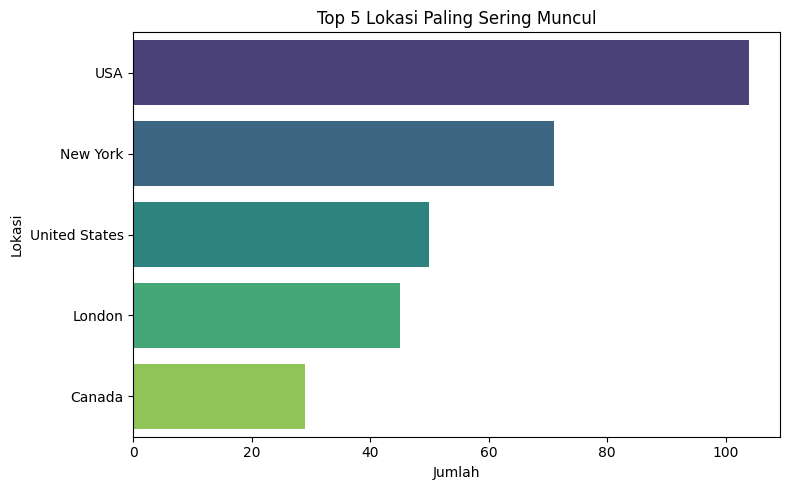

In [ ]:
# Ambil 5 lokasi teratas (pastikan kolom location tidak kosong)
top_locations = df['location'].dropna().value_counts().head(5)

# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
plt.title('Top 5 Lokasi Paling Sering Muncul')
plt.xlabel('Jumlah')
plt.ylabel('Lokasi')
plt.tight_layout()
plt.show()


# EDA

# Preprocessing

In [ ]:
# Muat model spaCy (pastikan sudah install: python -m spacy download en_core_web_sm)
import contractions
import string
nlp = spacy.load("en_core_web_sm")

# Custom stopwords tambahan dari kamu
custom_stop_words = {'u', 'going', 'youre', 'im', 'amp', 'get', 'like', 'dont', 'thats', 'one', 'http', 'co'}

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)  # Expand contractions
    text = re.sub(r'https?://\S+|www\.\S+', '', text)     # Hapus URL
    text = re.sub(r'<.*?>+', '', text)                    # Hapus tag HTML
    text = re.sub(r'\[.*?\]', '', text)                   # Hapus teks dalam kurung siku
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Hapus tanda baca
    text = re.sub(r'\n', ' ', text)                       # Ganti newline
    text = re.sub(r'\w*\d\w*', '', text)                  # Hapus kata berangka
    text = re.sub(r'[^\x00-\x7f]', r'', text)             # Hapus karakter non-ASCII (emoji, simbol asing)

    #stopword
    doc = nlp(text)
    cleaned_tokens = [
        token.lemma_ for token in doc
        if not token.is_stop                             # Stopword dari spaCy
        and token.lemma_ not in custom_stop_words        # Tambahan custom stopword
        and not token.is_punct
        and not token.is_space
        and len(token.lemma_) > 1                        # Hindari kata satu huruf
    ]

    return " ".join(cleaned_tokens).strip()
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

# Lihat hasil
df[['text', 'clean_text']].head(10)

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,send photo ruby alaska smoke wildfire pour school
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy close directio...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,hill fire wood
8,There's an emergency evacuation happening now ...,emergency evacuation happen building street
9,I'm afraid that the tornado is coming to our a...,afraid tornado come area


/tmp/ipython-input-13-671194560.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_words, palette='coolwarm')


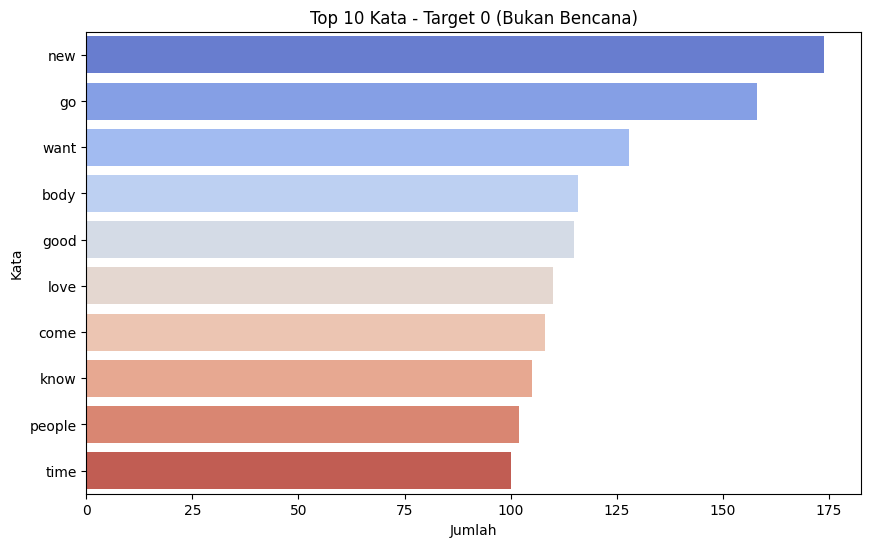

/tmp/ipython-input-13-671194560.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_words, palette='coolwarm')


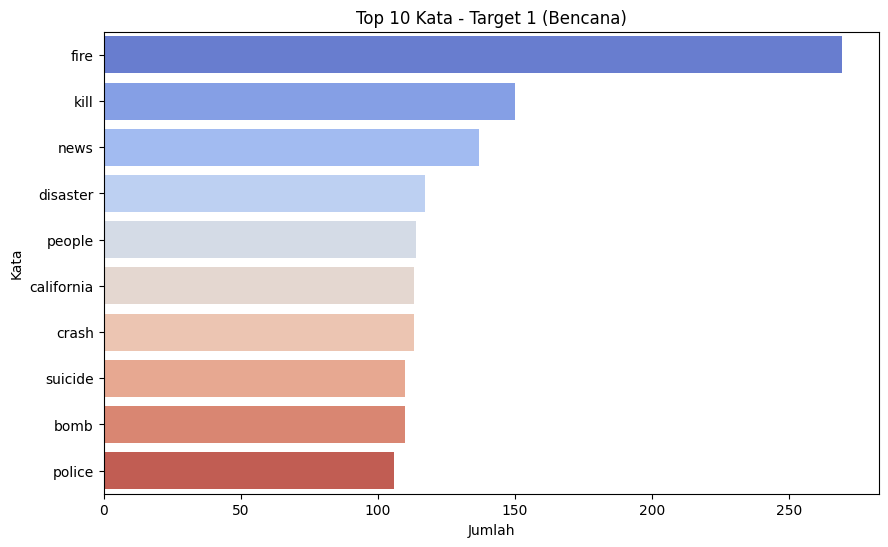

In [ ]:
import seaborn as sns
def get_top_words(label, top_n=10):
    all_words = ' '.join(df[df['target'] == label]['clean_text']).split()
    counter = Counter(all_words)
    top = counter.most_common(top_n)
    return pd.DataFrame(top, columns=['word', 'count'])

def plot_top_words(label):
    top_words = get_top_words(label)
    plt.figure(figsize=(10,6))
    sns.barplot(x='count', y='word', data=top_words, palette='coolwarm')
    plt.title(f"Top 10 Kata - Target {label} ({'Bencana' if label==1 else 'Bukan Bencana'})")
    plt.xlabel('Jumlah')
    plt.ylabel('Kata')
    plt.show()

# Tampilkan untuk kedua kelas
plot_top_words(0)  # Tidak Bencana
plot_top_words(1)  # Bencana


In [ ]:
df

,id,keyword,location,text,target,word_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,send photo ruby alaska smoke wildfire pour school
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,giant crane hold bridge collapse nearby home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,police investigate ebike collide car little po...


## Dataset Splitting

In [ ]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Naive Bayes

## Training

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_distributions = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__max_features': [3000, 5000, 7000],
    'algo__alpha': [0.1, 0.5, 1.0]
}


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer= word_tokenize, stop_words= 'english', ngram_range=(1,2), max_df=0.8,min_df=2, max_features=5000 )),
    ('algo', MultinomialNB(alpha=1))
])

model = RandomizedSearchCV(pipeline, param_distributions=param_distributions, cv=5, n_iter=50, n_jobs=-1, verbose=1, scoring='accuracy', random_state=42)
model.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.8,
                                                              max_features=5000,
                                                              min_df=2,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_words='english',
                                                              tokenizer=<function word_tokenize at 0x7af67bd4a5c0>)),
                                             ('algo', MultinomialNB(alpha=1))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__alpha': [0.1, 0.5, 1.0],
                                        'tfidf__max_df': [0.8, 0.9, 1.0],
                                        'tfidf__max_features': [3000, 5000,
                                                                7000],
                                        'tfidf__min_df': [1, 2],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)]},
                   random_state=42, scoring='accuracy', verbose=1)

## Evaluasi

In [ ]:
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 1, 'tfidf__max_features': 5000, 'tfidf__max_df': 0.8, 'algo__alpha': 1.0}
0.8673234811165845 0.7935960591133006 0.8135259356533159


In [ ]:
y_pred = model.predict(X_test)
y_pred_nb = y_pred

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Akurasi
acc = accuracy_score(y_test, y_pred)
print("Akurasi:", acc)

# Laporan klasifikasi (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Akurasi: 0.8135259356533159

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523


Confusion Matrix:
[[783  86]
 [198 456]]


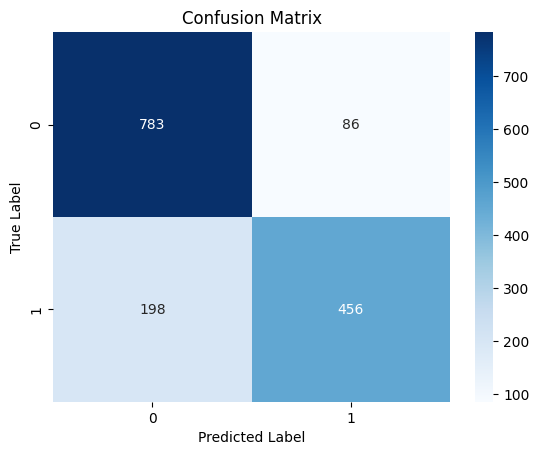

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Logistic Regression

## TF-IDF

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_df=0.9,
    min_df=2,
    stop_words='english',
    max_features=7000
)
# X_tfidf = tfidf.fit_transform(X['clean_text'])

X = df[['clean_text', 'word_count']]
y = df['target']

X_tfidf = tfidf.fit_transform(X['clean_text'])

In [ ]:
selector = SelectKBest(chi2, k=5000)
X_selected = selector.fit_transform(X_tfidf, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

## Training

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer # or CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold # Import StratifiedKFold
from sklearn.model_selection import train_test_split # Import train_test_split


In [ ]:
preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2, max_features=7000, stop_words='english'), 'clean_text')
])
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

In [ ]:
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear', 'saga'],
    'clf__class_weight': [None, 'balanced'],
    'preprocess__tfidf__ngram_range': [(1,1), (1,2)],
    'preprocess__tfidf__max_df': [0.75, 0.9],
    'preprocess__tfidf__min_df': [2, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Split data using the original DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2) # Use the pipeline as the estimator
grid.fit(X_train, y_train) # Fit using the original DataFrame split

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('tfidf',
                                                                         TfidfVectorizer(max_df=0.9,
                                                                                         max_features=7000,
                                                                                         min_df=2,
                                                                                         ngram_range=(1,
                                                                                                      2),
                                                                                         stop_words='english'),
                                                                         'clean_text')])),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__solver': ['liblinear', 'saga'],
                         'preprocess__tfidf__max_df': [0.75, 0.9],
                         'preprocess__tfidf__min_df': [2, 5],
                         'preprocess__tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=2)

## Evaluasi

In [ ]:
print("Best Parameters:", grid.best_params_)

y_pred = grid.predict(X_test)
y_pred_rl = y_pred
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__solver': 'liblinear', 'preprocess__tfidf__max_df': 0.75, 'preprocess__tfidf__min_df': 2, 'preprocess__tfidf__ngram_range': (1, 2)}
Accuracy: 0.814182534471438
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.81      0.81      1523



<Figure size 600x500 with 0 Axes>

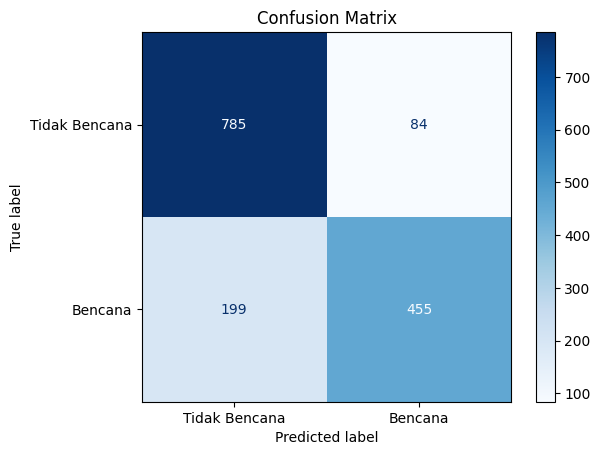

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Bencana', 'Bencana'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


##  

# Model interpretability

In [ ]:
# Ambil model terbaik dari GridSearchCV
final_model_rl = grid.best_estimator_
final_model_nb = model.best_estimator_


In [ ]:
# Mengidentifikasi lokasi menggunakan pos tagging pada data text_clean

def extract_location(text):
    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]
    return locations

def predict_disaster_rl(text):
    """
    Fungsi untuk memprediksi apakah sebuah teks merupakan bencana atau tidak.

    Args:
        text (str): Kalimat/teks input yang ingin diprediksi.

    Returns:
        int: 0 untuk 'tidak bencana', 1 untuk 'bencana'
    """
    data = pd.DataFrame({'clean_text': [text], 'word_count': [len(text.split())]})
    return final_model_rl.predict(data)[0]

def predict_disaster_nb(text):
    """
    Fungsi prediksi menggunakan model Naive Bayes (Model A).

    Args:
        text (str): Kalimat atau teks yang ingin diprediksi.

    Returns:
        int: 0 untuk 'tidak bencana', 1 untuk 'bencana'
    """
    return final_model_nb.predict([text])[0]

# keywords = df["keyword"].dropna().unique()
def detect_all_events(text):
    text_lower = text.lower()
    keywords = df["keyword"].dropna().unique()
    matched = [kw.lower() for kw in keywords if pd.notna(kw) and kw.lower() in text_lower]
    return matched if matched else "Unknown"

df['tagging_location'] = df['clean_text'].apply(extract_location)
df['prediction_target_rl'] = df['clean_text'].apply(predict_disaster_rl)
df['prediction_target_nb'] = df['clean_text'].apply(predict_disaster_nb)
df['extract_event'] = df['clean_text'].apply(detect_all_events)
df[['text', 'target', 'prediction_target_rl', 'prediction_target_nb', 'tagging_location', 'extract_event']]

,text,target,prediction_target_rl,prediction_target_nb,tagging_location,extract_event
0,Our Deeds are the Reason of this #earthquake M...,1,1,1,[],[earthquake]
1,Forest fire near La Ronge Sask. Canada,1,1,1,"[la, canada]",[fire]
2,All residents asked to 'shelter in place' are ...,1,1,1,[],[evacuation]
3,"13,000 people receive #wildfires evacuation or...",1,1,1,[california],"[evacuation, fire, wildfire]"
4,Just got sent this photo from Ruby #Alaska as ...,1,1,1,[alaska],"[fire, smoke, wildfire]"
...,...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,1,1,[],[collapse]
7609,@aria_ahrary @TheTawniest The out of control w...,1,1,1,[california],[fire]
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,1,1,[],[volcano]
7611,Police investigating after an e-bike collided ...,1,1,1,[portugal],"[collide, injury, police, threat]"


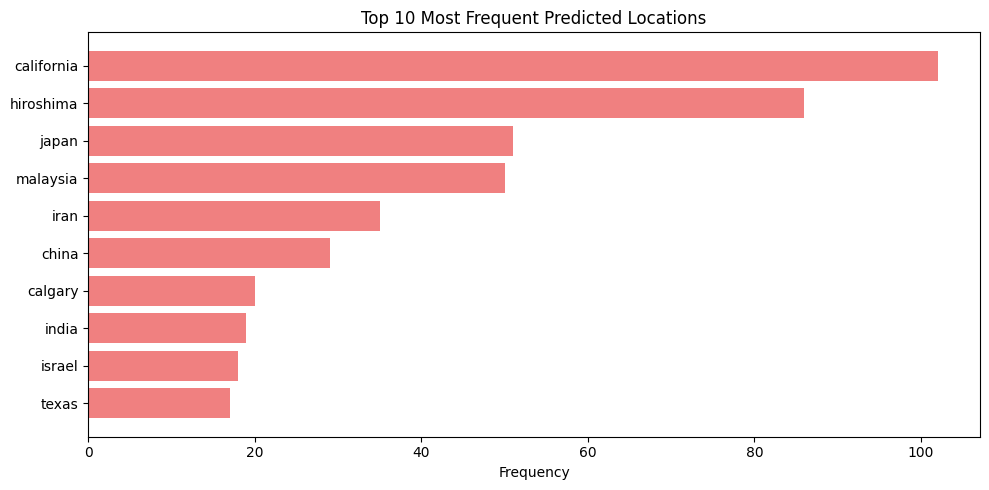

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Gabungkan semua lokasi dari tiap baris jadi satu list
all_locations = [loc for row in df['tagging_location'] for loc in row if loc]

# 2. Hitung frekuensi
top_locations = Counter(all_locations).most_common(10)

# 3. Buat DataFrame untuk visualisasi
top_loc_df = pd.DataFrame(top_locations, columns=['Location', 'Frequency'])

# 4. Plot
plt.figure(figsize=(10, 5))
plt.barh(top_loc_df['Location'], top_loc_df['Frequency'], color='lightcoral')
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Predicted Locations')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


/tmp/ipython-input-35-3377108622.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_df, x="count", y="event", palette="viridis")


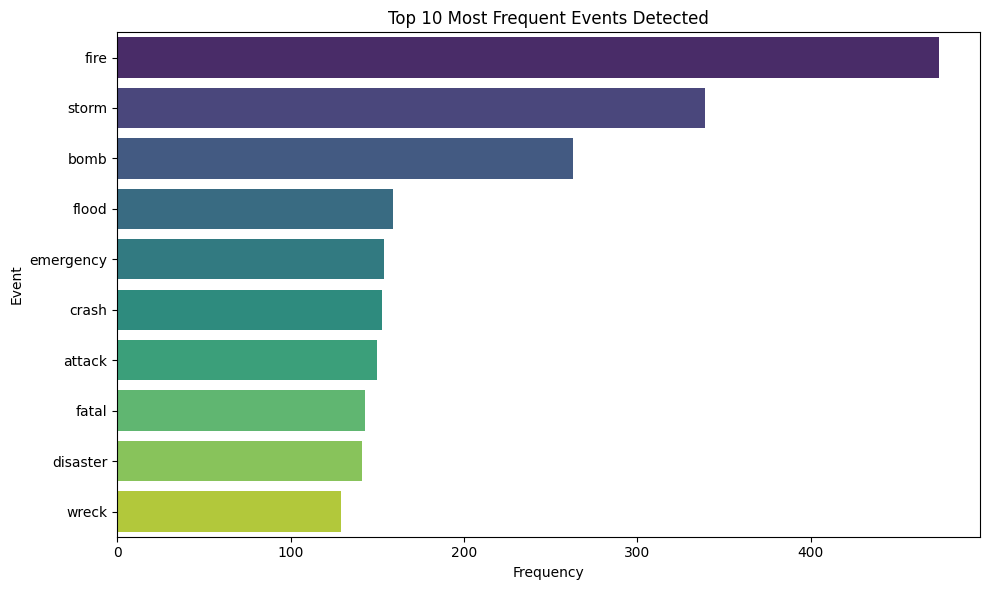

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from collections import Counter

# Explode list menjadi baris per item
all_events = df["extract_event"].explode()

# Drop yang "Unknown"
all_events = all_events[all_events != "Unknown"]

# Hitung frekuensi
event_counts = Counter(all_events)

# Ambil 10 besar
top_events = event_counts.most_common(10)

# Convert to DataFrame
event_df = pd.DataFrame(top_events, columns=["event", "count"])

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(data=event_df, x="count", y="event", palette="viridis")
plt.title("Top 10 Most Frequent Events Detected")
plt.xlabel("Frequency")
plt.ylabel("Event")
plt.tight_layout()
plt.show()


In [ ]:
sample = "Massive flood hits the southern part of the new york city"
disaster = predict_disaster_rl(sample)
location = extract_location(sample)
event = detect_all_events(sample)
print("Prediksi:", "Bencana" if disaster == 1 else "Tidak Bencana")
print("Lokasi:", location)
print("Event:", event)


Prediksi: Bencana
Lokasi: ['new york city']
Event: ['flood']
